# **Predicting High-Cost Medicare Beneficiaries: A Machine Learning Comparison Using CMS Synthetic Claims Data**

# **Part 3: Feature Engineering**

In this section, we'll be feature engineering to answer the following research questions:

Given previous years' information (up to the timestamp of 12/31 of the immediate precedent year), can we predict whether this beneficiary will be high-cost in the upcoming year?

For later stage iterations (during winter break), another research question (model 2) to be tackled would be:

Given previous years' information and 5 months of the current year's information (up to the timestamp of 5/31 of the current claim year), can we predict whether the beneficiary will be projected to high-cost in the current year?

**Parked model 2 right now due to time constraint and model complexity across claims.** Model 2 (out of scope currently) will consider 4 different scenarios: 
| Scenario | History? | First occurrence | Notes                                                              |
| -------- | -------- | ---------------- | ------------------------------------------------------------------ |
| 1a       | No       | Jan–May          | Early in year, no prior info                                       |
| 1b       | No       | Jun–Dec          | Later in year, no prior info                                       |
| 2a       | Yes      | Jan–May          | Early, has history — basically like Model A but partial-year input |
| 2b       | Yes      | Jun–Dec          | Late, has history — partial-year info                              |


In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from functools import reduce



# **3.1 Model 1 Feature Engineering**

In [2]:
bf = pd.read_pickle('cleaned_data/beneficiaries_cleaned.pkl')
ip = pd.read_pickle('cleaned_data/inpatient_cleaned.pkl')
op = pd.read_pickle('cleaned_data/outpatient_cleaned.pkl')
pde = pd.read_pickle('cleaned_data/pde_cleaned.pkl')
ca = pd.read_pickle("cleaned_data/carrier_a_cleaned.pkl")
cb = pd.read_pickle("cleaned_data/carrier_b_cleaned.pkl")

In [3]:
bf.head(1)

,DESYNPUF_ID,SP_STATE_CODE,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,...,BENRES_CAR,PPPYMT_CAR,year,is_dead,age,baseline_age,age_bin,sex,race,bene_esrd
0,000102649ED5601B,49,12,12,0,12,1,0,0,0,...,170.0,0.0,2008,0,77,77,75-79,Female,White,0


In [4]:
# Get IDs with more than 1 record
ids_to_keep = bf["DESYNPUF_ID"].value_counts()
ids_to_keep = ids_to_keep[ids_to_keep > 1].index

# Filter the dataframe
bf.drop(columns=['SP_STATE_CODE', 'BENE_HI_CVRAGE_TOT_MONS',
       'BENE_SMI_CVRAGE_TOT_MONS', 'BENE_HMO_CVRAGE_TOT_MONS',
       'PLAN_CVRG_MOS_NUM', 'is_dead', 'baseline_age', 'age_bin'], inplace=True)
bf1 = bf[bf["DESYNPUF_ID"].isin(ids_to_keep)]
bf1["DESYNPUF_ID"].value_counts()

DESYNPUF_ID
000102649ED5601B    3
A9A1EFDB4C508CB2    3
A9AD588999A72540    3
A9AD2F1E7BD35D85    3
A9AAAD4B88440EC6    3
                   ..
63135CB5E1CDECE4    2
155EE2ACC8DEC3A5    2
1C8E5F5B0AD990F1    2
6312CD969F4A451D    2
CEDF4E635CE5E549    2
Name: count, Length: 114495, dtype: int64

In [5]:
bf1.columns

Index(['DESYNPUF_ID', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR',
       'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
       'SP_RA_OA', 'SP_STRKETIA', 'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP',
       'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR',
       'PPPYMT_CAR', 'year', 'age', 'sex', 'race', 'bene_esrd'],
      dtype='object')

In [6]:
ip.drop(columns=['CLM_ID', 'SEGMENT', 'state_code', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_PASS_THRU_PER_DIEM_AMT',
       'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
       'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM'], inplace=True)

In [7]:
ip.columns

Index(['DESYNPUF_ID', 'CLM_FROM_DT', 'CLM_THRU_DT', 'CLM_UTLZTN_DAY_CNT',
       'year', 'claim_duration (days)', 'provider_category', 'ADMTNG_BUCKET',
       'PRIMARY_ICD9_BUCKET', 'UTIL_DAY_BUCKET'],
      dtype='object')

In [8]:
op.drop(columns=['CLM_ID', 'SEGMENT', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT',
       'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'NCH_BENE_PTB_DDCTBL_AMT',
       'NCH_BENE_PTB_COINSRNC_AMT', 'state_code'], inplace=True)

In [9]:
op.columns

Index(['DESYNPUF_ID', 'CLM_FROM_DT', 'CLM_THRU_DT', 'year',
       'claim_duration (days)', 'provider_category', 'ADMTNG_BUCKET',
       'DGNS1_BUCKET', 'HCPCS_BUCKET'],
      dtype='object')

In [10]:
pde.drop(columns=['PDE_ID', 'PTNT_PAY_AMT'], inplace=True)

In [11]:
pde.columns

Index(['DESYNPUF_ID', 'SRVC_DT', 'QTY_DSPNSD_NUM', 'DAYS_SUPLY_NUM',
       'TOT_RX_CST_AMT', 'year', 'NDC_BUCKET'],
      dtype='object')

In [12]:
ca.drop(columns=['total_line_nch_payment',
       'total_line_allowed_charge', 'total_line_coinsurance',
       'total_line_deductible', 'total_primary_payer_amount'], inplace=True)
cb.drop(columns=['total_line_nch_payment',
       'total_line_allowed_charge', 'total_line_coinsurance',
       'total_line_deductible', 'total_primary_payer_amount'], inplace=True)

In [13]:
cb.columns

Index(['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_THRU_DT', 'year',
       'claim_duration (days)', 'DGNS1_BUCKET', 'HCPCS_BUCKET'],
      dtype='object')

In [14]:
ip.dtypes

DESYNPUF_ID                      object
CLM_FROM_DT              datetime64[ns]
CLM_THRU_DT              datetime64[ns]
CLM_UTLZTN_DAY_CNT              float64
year                            float64
claim_duration (days)           float64
provider_category              category
ADMTNG_BUCKET                  category
PRIMARY_ICD9_BUCKET            category
UTIL_DAY_BUCKET                category
dtype: object

In [15]:
def aggregate_claims(df, numeric_cols, categorical_cols, prefix):
    """
    Aggregates a claim-level table to patient-year level and one-hot encodes categorical columns.
    
    Parameters:
        df (pd.DataFrame): Claim-level dataframe
        numeric_cols (list): Numeric columns to sum
        categorical_cols (list): Categorical columns to one-hot encode
        prefix (str): Prefix to add to column names (e.g., "IP", "OP")
    
    Returns:
        pd.DataFrame: Aggregated & one-hot encoded patient-year dataframe
    """
    df = df.copy()
    
    # Aggregate numeric columns (sum)
    agg_dict = {col: 'sum' for col in numeric_cols}
    
    # Aggregate categorical columns as list of unique values
    agg_dict.update({col: pd.Series.unique for col in categorical_cols})
    
    df_agg = df.groupby(['DESYNPUF_ID', 'year']).agg(agg_dict).reset_index()
    
    # One-hot encode categorical columns
    for col in categorical_cols:
        mlb = MultiLabelBinarizer()
        one_hot = pd.DataFrame(
            mlb.fit_transform(df_agg[col]),
            columns=[f"{prefix}_{col}_{c}" for c in mlb.classes_],
            index=df_agg.index
        )
        df_agg = pd.concat([df_agg.drop(columns=[col]), one_hot], axis=1)
    
    # Add prefix to numeric columns
    df_agg = df_agg.rename(columns={col: f"{prefix}_{col}" for col in numeric_cols})
    
    return df_agg


In [16]:
def prepare_model_a(df_bene, df_ip, df_op, df_pde, df_carrier_a, df_carrier_b):
    """
    Prepares patient-year level dataset from multiple claim tables.
    Returns one row per patient-year with aggregated features.
    """
    # Beneficiary table 
    df_bene = df_bene.copy()
    
    # Keep demographics & chronic conditions only
    bene_cols = ['DESYNPUF_ID', 'year', 'age', 'sex', 'race', 'bene_esrd',
                 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR',
                 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT',
                 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
                 'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP',
                 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP',
                 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR']
    df_bene = df_bene[bene_cols]
    
    # Inpatient
    numeric_cols_ip = ['CLM_UTLZTN_DAY_CNT', 'claim_duration (days)']
    categorical_cols_ip = ['provider_category', 'ADMTNG_BUCKET', 
                           'PRIMARY_ICD9_BUCKET', 'UTIL_DAY_BUCKET']
    df_ip_agg = aggregate_claims(df_ip, numeric_cols_ip, categorical_cols_ip, prefix='IP')
    
    # Outpatient 
    numeric_cols_op = ['claim_duration (days)']
    categorical_cols_op = ['provider_category', 'ADMTNG_BUCKET', 
                          'DGNS1_BUCKET', 'HCPCS_BUCKET']
    df_op_agg = aggregate_claims(df_op, numeric_cols_op, categorical_cols_op, prefix='OP')
    
    # PDE 
    numeric_cols_pde = ['QTY_DSPNSD_NUM', 'DAYS_SUPLY_NUM', 'TOT_RX_CST_AMT']
    categorical_cols_pde = ['NDC_BUCKET']
    df_pde_agg = aggregate_claims(df_pde, numeric_cols_pde, categorical_cols_pde, prefix='PDE')
    
    # Carrier (merge a + b first) 
    df_carrier = pd.concat([df_carrier_a, df_carrier_b], axis=0, ignore_index=True)
    numeric_cols_car = ['claim_duration (days)']
    categorical_cols_car = ['DGNS1_BUCKET', 'HCPCS_BUCKET']
    df_carrier_agg = aggregate_claims(df_carrier, numeric_cols_car, 
                                     categorical_cols_car, prefix='CAR')
    
    # Merge all aggregated tables 
    dfs = [df_bene, df_ip_agg, df_op_agg, df_pde_agg, df_carrier_agg]
    df_final = reduce(lambda left, right: pd.merge(left, right, 
                                                    on=['DESYNPUF_ID','year'], 
                                                    how='left'), dfs)
    
    # Fill NaN values in one-hot encoded columns with 0
    one_hot_cols = [col for col in df_final.columns 
                    if any(prefix in col for prefix in ['IP_', 'OP_', 'PDE_', 'CAR_'])]
    df_final[one_hot_cols] = df_final[one_hot_cols].fillna(0)
    
    return df_final

In [17]:
db1 = prepare_model_a(bf1, ip, op, pde, ca, cb)
db1.head()

,DESYNPUF_ID,year,age,sex,race,bene_esrd,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,...,CAR_DGNS1_BUCKET_neurologic,CAR_DGNS1_BUCKET_other,CAR_DGNS1_BUCKET_respiratory,CAR_HCPCS_BUCKET_cardiac_procedure,CAR_HCPCS_BUCKET_imaging,CAR_HCPCS_BUCKET_lab_blood_draw,CAR_HCPCS_BUCKET_missing,CAR_HCPCS_BUCKET_office_visit,CAR_HCPCS_BUCKET_other,CAR_HCPCS_BUCKET_therapy
0,000102649ED5601B,2008,77,Female,White,0,1,0,0,0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
1,000102649ED5601B,2009,78,Female,White,0,1,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,000102649ED5601B,2010,79,Female,White,0,1,0,0,0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0002278C944E240A,2008,72,Female,White,1,1,1,1,0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0002278C944E240A,2009,73,Female,White,1,1,1,1,0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [18]:
sp_cols = [
    'bene_esrd', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR',
    'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 
    'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA'
]

db1[sp_cols] = db1[sp_cols].astype(float)

In [19]:
def add_history_features_fast(df, id_col='DESYNPUF_ID', year_col='year', 
                               numeric_cols=None, onehot_cols=None):
    """
    Adds historical features (lagged means and cumulative sums).
    
    For onehot_cols: Creates cumulative count of how many times in PREVIOUS years
    this specific condition/procedure/diagnosis appeared (e.g., if they had 
    imaging in 2008 and 2009, in 2010 the history_sum would be 2).
    
    Parameters:
        df: DataFrame with one row per patient-year
        numeric_cols: Columns to compute expanding mean (lagged)
        onehot_cols: Binary/count columns to compute cumulative sum (lagged)
    
    Returns:
        DataFrame with added history columns
    """
    df = df.copy()
    
    # --- SORT FIRST (critical -- or lol the historical data will be a mess) ---
    df = df.sort_values([id_col, year_col]).reset_index(drop=True)
    
    history_cols = {}
    
    # Numeric histories: expanding mean of previous years
    if numeric_cols:
        for col in numeric_cols:
            history_cols[col + '_history_mean'] = (
                df.groupby(id_col, group_keys=False)[col]
                  .apply(lambda x: x.shift(1).expanding().mean())
            )
    
    # Categorical one-hot histories: cumulative sum of previous years
    # This counts "how many times has this patient had this specific thing before"
    if onehot_cols:
        for col in onehot_cols:
            history_cols[col + '_history_sum'] = (
                df.groupby(id_col, group_keys=False)[col]
                  .apply(lambda x: x.cumsum().shift(1))
            )
    
    history_df = pd.DataFrame(history_cols).fillna(0)
    df = pd.concat([df, history_df], axis=1)
    
    return df

In [20]:
# Define which columns need history features
numeric_cols = [
    'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP',
    'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP',
    'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR',
    'IP_CLM_UTLZTN_DAY_CNT', 'IP_claim_duration (days)', 
    'OP_claim_duration (days)', 'CAR_claim_duration (days)', 
    'PDE_TOT_RX_CST_AMT'
]

# Prefixes for one-hot encoded columns
prefixes = [
    'IP_provider', 'IP_ADMTNG', 'IP_PRIMARY', 'IP_UTIL_DAY',
    'OP_provider_category', 'OP_ADMTNG', 'OP_DGNS1', 'OP_HCPCS',
    'PDE_NDC_BUCKET', 'CAR_DGNS1', 'CAR_HCPCS'
]

# Find all one-hot columns
onehot_cols = [col for col in db1.columns 
               if any(col.startswith(pref) for pref in prefixes)]

# Add history features
df_final = add_history_features_fast(
    db1,
    numeric_cols=numeric_cols,
    onehot_cols=onehot_cols
)

print(df_final.head())
print(f"\nShape: {df_final.shape}")
print(f"Columns: {df_final.columns.tolist()}")


        DESYNPUF_ID  year  age     sex   race  bene_esrd  SP_ALZHDMTA  SP_CHF  \
0  000102649ED5601B  2008   77  Female  White        0.0          1.0     0.0   
1  000102649ED5601B  2009   78  Female  White        0.0          1.0     0.0   
2  000102649ED5601B  2010   79  Female  White        0.0          1.0     0.0   
3  0002278C944E240A  2008   72  Female  White        1.0          1.0     1.0   
4  0002278C944E240A  2009   73  Female  White        1.0          1.0     1.0   

   SP_CHRNKIDN  SP_CNCR  ...  CAR_DGNS1_BUCKET_neurologic_history_sum  \
0          0.0      0.0  ...                                      0.0   
1          0.0      0.0  ...                                      0.0   
2          0.0      0.0  ...                                      0.0   
3          1.0      0.0  ...                                      0.0   
4          1.0      0.0  ...                                      0.0   

   CAR_DGNS1_BUCKET_other_history_sum  \
0                                

In [21]:
df_final['no_prior_info'] = (df_final['year'] == 2008).astype(int)

In [22]:
df_final[["DESYNPUF_ID","year", "CAR_HCPCS_BUCKET_imaging", "CAR_HCPCS_BUCKET_imaging_history_sum", "MEDREIMB_IP", "MEDREIMB_IP_history_mean" ]].head(20)

,DESYNPUF_ID,year,CAR_HCPCS_BUCKET_imaging,CAR_HCPCS_BUCKET_imaging_history_sum,MEDREIMB_IP,MEDREIMB_IP_history_mean
0,000102649ED5601B,2008,1.0,0.0,0.0,0.0
1,000102649ED5601B,2009,1.0,1.0,0.0,0.0
2,000102649ED5601B,2010,1.0,2.0,0.0,0.0
3,0002278C944E240A,2008,1.0,0.0,0.0,0.0
4,0002278C944E240A,2009,1.0,1.0,96000.0,0.0
5,0002278C944E240A,2010,1.0,2.0,3040.0,48000.0
6,000330E625C93700,2008,1.0,0.0,0.0,0.0
7,000330E625C93700,2009,1.0,1.0,0.0,0.0
8,000330E625C93700,2010,0.0,2.0,0.0,0.0
9,000374D5E110EDA6,2008,0.0,0.0,0.0,0.0


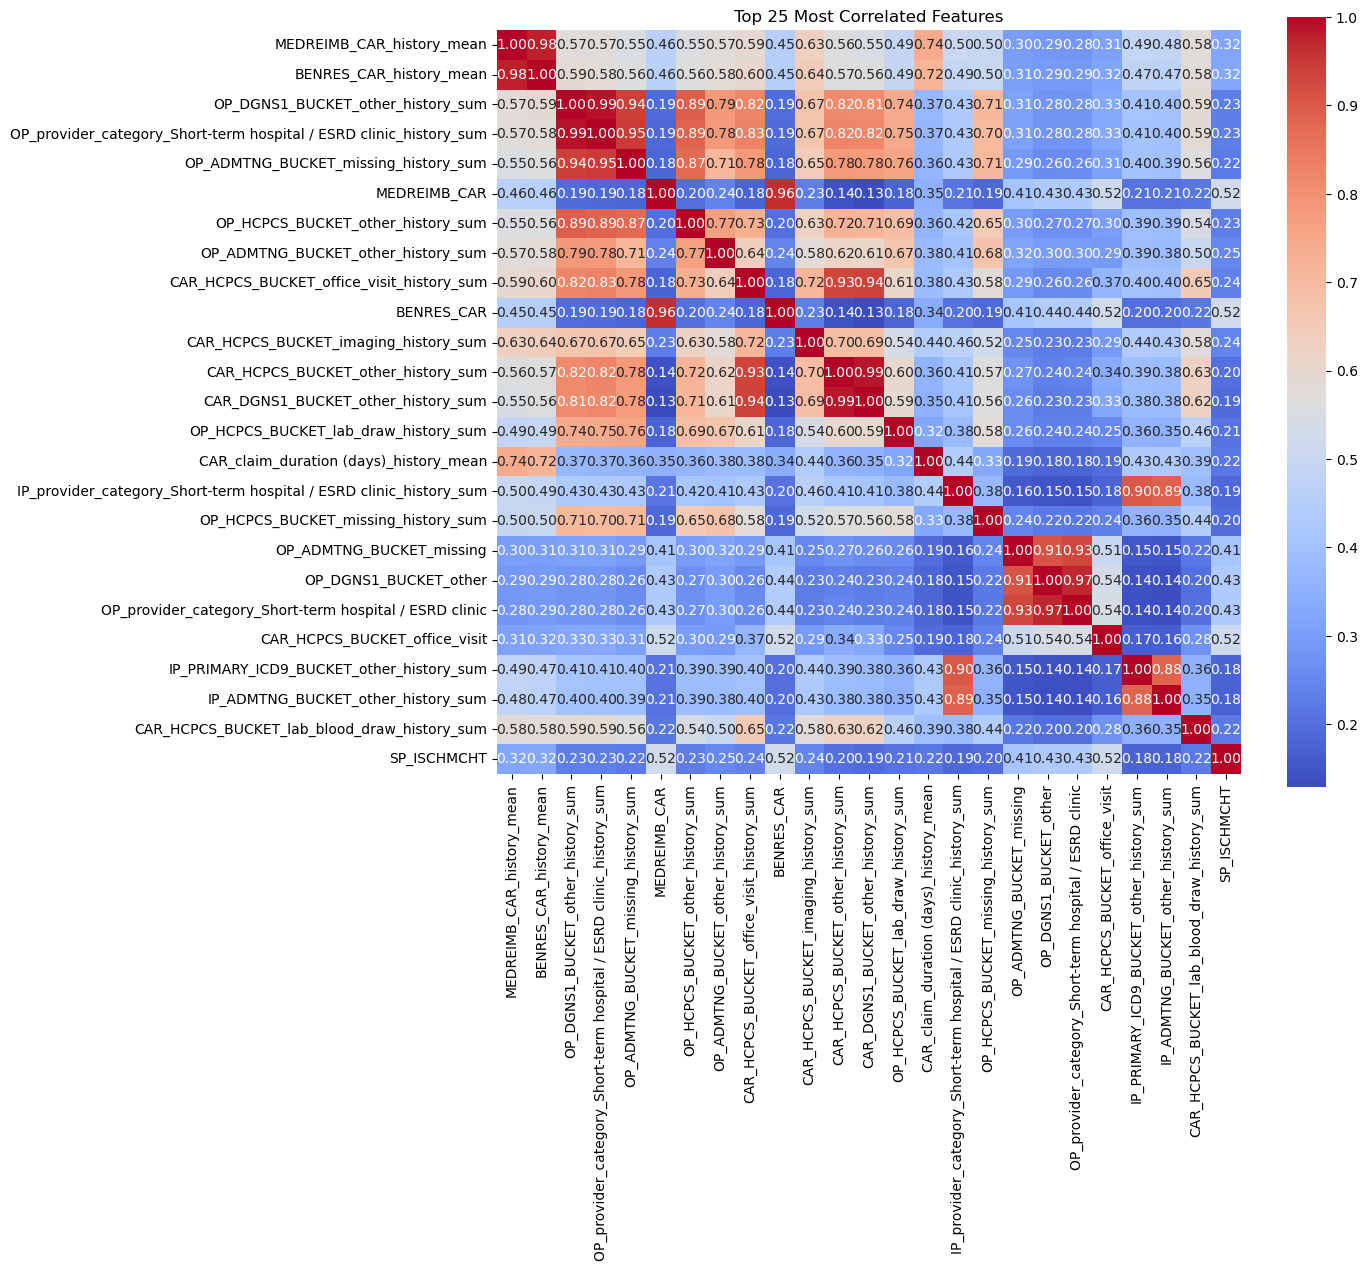

In [23]:
# Compute correlation matrix
numeric_df = df_final.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr().abs()

# Find the top 25 most correlated features
top_features = corr_matrix.sum().sort_values(ascending=False).head(25).index

# Slice the correlation matrix to these top features
top_corr = corr_matrix.loc[top_features, top_features]

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(top_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Top 25 Most Correlated Features")
plt.show()


In [24]:
# Compute correlation matrix
corr_matrix = numeric_df.corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation above a threshold (e.g., 0.9)
threshold = 0.85
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"Features to drop due to high correlation (> {threshold}):")
print(to_drop)

# Drop them
numeric_df_reduced = numeric_df.drop(columns=to_drop)



Features to drop due to high correlation (> 0.85):
['BENRES_CAR', 'IP_claim_duration (days)', 'IP_ADMTNG_BUCKET_other', 'IP_PRIMARY_ICD9_BUCKET_other', 'IP_PRIMARY_ICD9_BUCKET_renal_dialysis', 'OP_ADMTNG_BUCKET_missing', 'OP_DGNS1_BUCKET_other', 'PDE_DAYS_SUPLY_NUM', 'PDE_TOT_RX_CST_AMT', 'CAR_HCPCS_BUCKET_other', 'BENRES_OP_history_mean', 'BENRES_CAR_history_mean', 'IP_claim_duration (days)_history_mean', 'IP_ADMTNG_BUCKET_other_history_sum', 'IP_PRIMARY_ICD9_BUCKET_other_history_sum', 'IP_PRIMARY_ICD9_BUCKET_renal_dialysis_history_sum', 'OP_ADMTNG_BUCKET_missing_history_sum', 'OP_DGNS1_BUCKET_other_history_sum', 'OP_HCPCS_BUCKET_other_history_sum', 'CAR_HCPCS_BUCKET_office_visit_history_sum', 'CAR_HCPCS_BUCKET_other_history_sum', 'no_prior_info']


In [25]:
df_final.drop(columns=['BENRES_CAR', 'IP_claim_duration (days)', 'IP_PRIMARY_ICD9_BUCKET_renal_dialysis', 'PDE_DAYS_SUPLY_NUM', 'BENRES_OP_history_mean', 'BENRES_CAR_history_mean', 'IP_claim_duration (days)_history_mean', 'IP_ADMTNG_BUCKET_other_history_sum', 'IP_PRIMARY_ICD9_BUCKET_other_history_sum', 'IP_PRIMARY_ICD9_BUCKET_renal_dialysis_history_sum', 'OP_ADMTNG_BUCKET_missing_history_sum', 'OP_DGNS1_BUCKET_other_history_sum', 'OP_HCPCS_BUCKET_other_history_sum', 'CAR_HCPCS_BUCKET_office_visit_history_sum', 
                         'CAR_HCPCS_BUCKET_other_history_sum'], inplace=True)

In [26]:
df_final.drop(columns=['IP_ADMTNG_BUCKET_other', 'IP_PRIMARY_ICD9_BUCKET_other', 'OP_ADMTNG_BUCKET_missing', 'OP_DGNS1_BUCKET_other', 'CAR_HCPCS_BUCKET_other'], inplace=True) 

In [27]:
df_final["total_payer_cost"] = df_final['MEDREIMB_IP'] + df_final['MEDREIMB_OP'] + df_final['MEDREIMB_CAR'] + df_final['PDE_TOT_RX_CST_AMT']

In [28]:
top10_cutoffs = {
    2008: 16574.0,
    2009: 17279.4,
    2010: 9830.0
}

# Create a new column 'high_cost' based on year-specific cutoff
df_final['high_cost'] = df_final.apply(
    lambda row: 1 if row['total_payer_cost'] >= top10_cutoffs[row['year']] else 0,
    axis=1
)

In [29]:
df_final.drop(columns=["total_payer_cost", "PDE_TOT_RX_CST_AMT"], inplace=True)

In [30]:
df_final[df_final['DESYNPUF_ID'] == '0002278C944E240A']
df_final.groupby(['DESYNPUF_ID', 'year']).size()

DESYNPUF_ID       year
000102649ED5601B  2008    1
                  2009    1
                  2010    1
0002278C944E240A  2008    1
                  2009    1
                         ..
FFFE4E347796686D  2009    1
                  2010    1
FFFFEE90E1B4D0DF  2008    1
                  2009    1
                  2010    1
Length: 341675, dtype: int64

In [31]:
# Create folder if it doesn't exist
folder = "model_data"
os.makedirs(folder, exist_ok=True)

# Save beneficiaries
with open(os.path.join(folder, 'df_model_a.pkl'), 'wb') as f:
    pickle.dump(df_final, f)